In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from datetime import datetime
from datetime import timedelta
from keras.preprocessing.sequence import TimeseriesGenerator

2023-02-05 04:51:13.500916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, LeakyReLU

In [71]:
starts_ends_1299 = pd.read_csv("start_end_1299.csv")
starts_ends_1299['start_time_hour'] = pd.to_datetime(starts_ends_1299['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
starts_ends_1299 = starts_ends_1299.set_index('start_time_hour') 
se1299 = starts_ends_1299[(starts_ends_1299.index.get_level_values(0) > '2021-12-31')]

In [72]:
bike_inv = se1299.asfreq(pd.infer_freq(se1299.index))

train_data = bike_inv[0:-504]
val_data = bike_inv[-504:-168]
test_data = bike_inv[-168:-1]

### 1 feature LSTM

In [73]:
n_input = 24
batch_size = 8

train_gen = TimeseriesGenerator(train_data.bike_diff, train_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)
val_gen = TimeseriesGenerator(val_data.bike_diff, val_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)
test_gen = TimeseriesGenerator(test_data.bike_diff, test_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(n_input, 1), return_sequences=True))
model.add(LeakyReLU())
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 128)           66560     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 128)           131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 24, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [75]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_gen, epochs = 50, 
                              validation_data=val_gen,
                             shuffle=False, callbacks=[early_stop])

Epoch 1/50
402/402 [==============================] - 13s 26ms/step - loss: 3.4854 - mean_absolute_error: 0.8482 - val_loss: 5.7174 - val_mean_absolute_error: 1.3267
Epoch 2/50
402/402 [==============================] - 10s 24ms/step - loss: 3.4551 - mean_absolute_error: 0.8728 - val_loss: 5.6500 - val_mean_absolute_error: 1.3240
Epoch 3/50
402/402 [==============================] - 10s 24ms/step - loss: 3.4358 - mean_absolute_error: 0.8773 - val_loss: 5.5787 - val_mean_absolute_error: 1.3240
Epoch 4/50
402/402 [==============================] - 9s 24ms/step - loss: 3.4051 - mean_absolute_error: 0.8863 - val_loss: 5.4866 - val_mean_absolute_error: 1.3167
Epoch 5/50
402/402 [==============================] - 9s 23ms/step - loss: 3.3791 - mean_absolute_error: 0.8902 - val_loss: 5.3913 - val_mean_absolute_error: 1.3037
Epoch 6/50
402/402 [==============================] - 9s 24ms/step - loss: 3.3518 - mean_absolute_error: 0.8943 - val_loss: 5.3606 - val_mean_absolute_error: 1.3155
Epoch 7

In [76]:
predictions = model.predict_generator(test_gen)
new_df = test_data[24:]
new_df["pred_bike_diff"] = predictions

Text(0, 0.5, 'Inv. Change')

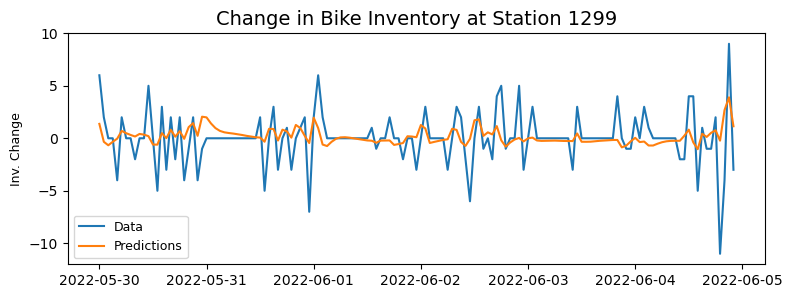

In [77]:
plt.figure(figsize=(9,3))

plt.plot(new_df["bike_diff"], label='data')
plt.plot(new_df["pred_bike_diff"], label='prediction')

plt.legend(('Data', 'Predictions'), fontsize=9)

plt.title('Change in Bike Inventory at Station 1299', fontsize=14)
plt.ylabel('Inv. Change', fontsize=9)

#### Reducing the amount of Lags to 4

In [57]:
n_input = 4
batch_size = 16

train_gen = TimeseriesGenerator(train_data.bike_diff, train_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)
val_gen = TimeseriesGenerator(val_data.bike_diff, val_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)
test_gen = TimeseriesGenerator(test_data.bike_diff, test_data.bike_diff, length=n_input, batch_size=batch_size, sampling_rate=1)

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(n_input, 1), return_sequences=True))
model.add(LeakyReLU())
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_gen, epochs = 50, 
                              validation_data=val_gen,
                             shuffle=False, callbacks=[early_stop])

Epoch 1/50
294/294 [==============================] - 5s 9ms/step - loss: 3.0617 - mean_absolute_error: 0.7624 - val_loss: 5.8020 - val_mean_absolute_error: 1.3272
Epoch 2/50
294/294 [==============================] - 2s 7ms/step - loss: 3.0307 - mean_absolute_error: 0.7810 - val_loss: 5.6954 - val_mean_absolute_error: 1.3298
Epoch 3/50
294/294 [==============================] - 2s 7ms/step - loss: 3.0153 - mean_absolute_error: 0.7826 - val_loss: 5.6185 - val_mean_absolute_error: 1.3204
Epoch 4/50
294/294 [==============================] - 2s 7ms/step - loss: 2.9754 - mean_absolute_error: 0.7840 - val_loss: 5.4887 - val_mean_absolute_error: 1.3197
Epoch 5/50
294/294 [==============================] - 2s 7ms/step - loss: 2.9373 - mean_absolute_error: 0.7899 - val_loss: 5.3613 - val_mean_absolute_error: 1.3099
Epoch 6/50
294/294 [==============================] - 2s 7ms/step - loss: 2.9016 - mean_absolute_error: 0.7993 - val_loss: 5.2939 - val_mean_absolute_error: 1.3149
Epoch 7/50
294/2

In [62]:
predictions = model.predict_generator(test_gen)
new_df = test_data[4:]
new_df["pred_bike_diff"] = predictions

Text(0, 0.5, 'Inv. Change')

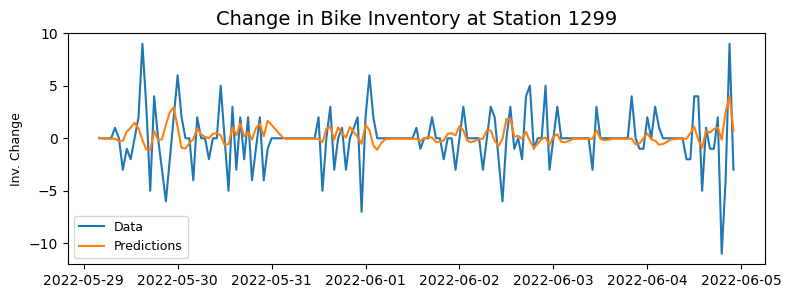

In [63]:
plt.figure(figsize=(9,3))

plt.plot(new_df["bike_diff"], label='data')
plt.plot(new_df["pred_bike_diff"], label='prediction')

plt.legend(('Data', 'Predictions'), fontsize=9)

plt.title('Change in Bike Inventory at Station 1299', fontsize=14)
plt.ylabel('Inv. Change', fontsize=9)

### Multivariate LSTM

In [52]:
var_input = pd.read_csv("VAR_inputs.csv")

var_input['start_time_hour'] = pd.to_datetime(var_input['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
var_input = var_input.set_index('start_time_hour') 

var_input['bike_diff'] = var_input['bike_diff'].astype(float)
var_input['bike_diff_1319'] = var_input['bike_diff_1319'].astype(float)
var_input['bike_diff_1435'] = var_input['bike_diff_1435'].astype(float)

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(var_input)

scaled_train = scaled_data[0:-504,:]
scaled_val = scaled_data[-504:-168,:]
scaled_test = scaled_data[-168:-1,:]

In [37]:
train_data = var_input[0:-504]
y_train = var_input[0:-504]["bike_diff"]

val_data = var_input[-504:-168]
y_val = var_input[-504:-168]["bike_diff"]

test_data = var_input[-168:-1]
y_test = var_input[-168:-1]["bike_diff"]

In [43]:
n_input = 5
batch_size = 8
num_features=3

train_gen = TimeseriesGenerator(train_data.to_numpy(), y_train.to_numpy(), length=n_input, batch_size=batch_size, sampling_rate=1)
val_gen = TimeseriesGenerator(val_data.to_numpy(), y_val.to_numpy(), length=n_input, batch_size=batch_size, sampling_rate=1)
test_gen = TimeseriesGenerator(test_data.to_numpy(), y_test.to_numpy(), length=n_input, batch_size=1)

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(n_input, num_features), return_sequences=True))
model.add(LeakyReLU())
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

In [45]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_gen, epochs = 50, 
                              validation_data=val_gen,
                             shuffle=False, callbacks=[early_stop])

Epoch 1/50
405/405 [==============================] - 8s 11ms/step - loss: 3.4909 - mean_absolute_error: 0.8382 - val_loss: 5.7614 - val_mean_absolute_error: 1.3264
Epoch 2/50
405/405 [==============================] - 4s 9ms/step - loss: 3.4688 - mean_absolute_error: 0.8497 - val_loss: 5.6702 - val_mean_absolute_error: 1.3209
Epoch 3/50
405/405 [==============================] - 4s 9ms/step - loss: 3.4393 - mean_absolute_error: 0.8527 - val_loss: 5.5859 - val_mean_absolute_error: 1.3197
Epoch 4/50
405/405 [==============================] - 4s 9ms/step - loss: 3.4110 - mean_absolute_error: 0.8600 - val_loss: 5.5180 - val_mean_absolute_error: 1.3162
Epoch 5/50
405/405 [==============================] - 4s 9ms/step - loss: 3.3687 - mean_absolute_error: 0.8656 - val_loss: 5.4459 - val_mean_absolute_error: 1.3147
Epoch 6/50
405/405 [==============================] - 4s 9ms/step - loss: 3.3123 - mean_absolute_error: 0.8699 - val_loss: 5.3610 - val_mean_absolute_error: 1.3259
Epoch 7/50
405/

In [50]:
predictions = model.predict_generator(test_gen)
new_df = test_data[n_input:]
new_df["pred_bike_diff"] = predictions

Text(0, 0.5, 'Inv. Change')

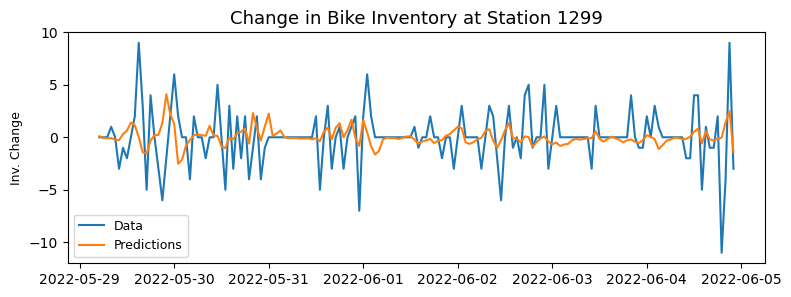

In [51]:
plt.figure(figsize=(9,3))

plt.plot(new_df["bike_diff"], label='data')
plt.plot(new_df["pred_bike_diff"], label='prediction')

plt.legend(('Data', 'Predictions'), fontsize=9)

plt.title('Change in Bike Inventory at Station 1299', fontsize=13)
plt.ylabel('Inv. Change', fontsize=9)

#### Multivariate LSTM with Scaling -- results were worse

In [67]:
n_input = 5
batch_size = 8
num_features=3

train_gen = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=batch_size, sampling_rate=1)
val_gen = TimeseriesGenerator(scaled_val, scaled_val[:,0], length=n_input, batch_size=batch_size, sampling_rate=1)
test_gen = TimeseriesGenerator(scaled_test, scaled_test[:,0], length=n_input, batch_size=1)

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_gen, epochs = 50, 
                              validation_data=val_gen,
                             shuffle=False, callbacks=[early_stop])

Epoch 1/50
405/405 [==============================] - 8s 12ms/step - loss: 0.0073 - mean_absolute_error: 0.0628 - val_loss: 0.0077 - val_mean_absolute_error: 0.0598
Epoch 2/50
405/405 [==============================] - 4s 9ms/step - loss: 0.0068 - mean_absolute_error: 0.0602 - val_loss: 0.0070 - val_mean_absolute_error: 0.0478
Epoch 3/50
405/405 [==============================] - 4s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0589 - val_loss: 0.0074 - val_mean_absolute_error: 0.0565
Epoch 4/50
405/405 [==============================] - 4s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0584 - val_loss: 0.0071 - val_mean_absolute_error: 0.0533


In [69]:
predictions = model.predict_generator(test_gen)

In [80]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(scaled_test[:,1:][n_input:])], axis=1)
rev_trans = scaler.inverse_transform(df_pred)

In [85]:
new_df = var_input[-168+n_input:-1]
new_df

,bike_diff,bike_diff_1319,bike_diff_1435
start_time_hour,,,
2022-05-29 05:00:00,0.0,0.0,0.0
2022-05-29 06:00:00,0.0,0.0,0.0
2022-05-29 07:00:00,0.0,0.0,0.0
2022-05-29 08:00:00,1.0,0.0,-1.0
2022-05-29 09:00:00,0.0,0.0,0.0
...,...,...,...
2022-06-04 18:00:00,2.0,0.0,-3.0
2022-06-04 19:00:00,-11.0,3.0,3.0
2022-06-04 20:00:00,-4.0,-6.0,7.0


In [87]:
new_df = var_input[-168+n_input:-1]
new_df["pred_bike_diff"] = rev_trans[:,0]

Text(0, 0.5, 'Inv. Change')

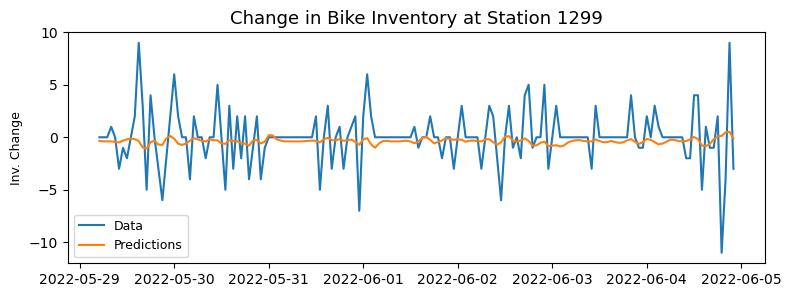

In [88]:
plt.figure(figsize=(9,3))

plt.plot(new_df["bike_diff"], label='data')
plt.plot(new_df["pred_bike_diff"], label='prediction')

plt.legend(('Data', 'Predictions'), fontsize=9)

plt.title('Change in Bike Inventory at Station 1299', fontsize=13)
plt.ylabel('Inv. Change', fontsize=9)

In [89]:
residuals = new_df.bike_diff - new_df.pred_bike_diff
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.5596131931279924
